###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
 

In [1]:
#import libraries
import tensorflow as tf
import keras
from keras.models import Sequential , Model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D , Dense, Conv2D, MaxPool2D , Flatten , concatenate ,DepthwiseConv2D, GlobalAveragePooling2D , ReLU

In [2]:
print(tf.__version__)

2.6.4


In [3]:
print(keras.__version__)

2.6.0


# # Preparing Dataset

In [4]:
photo_size = 224
batch_size=32
def prepare_dataset(data_dir):
    datagen = ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(photo_size,photo_size),
        class_mode='binary',
        batch_size=batch_size,
        classes=['non_autistic','autistic']
    )
    return generator

# Load Dataset

In [5]:
#load dataset
traindata = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/train")
testdata= prepare_dataset("/kaggle/input/autistic-children-facial-data-set/test")
validData = prepare_dataset("/kaggle/input/autistic-children-facial-data-set/valid")

Found 2536 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
print(traindata.samples)

2536


# Improved MobileNet v1

In [7]:
def depth_block(x, strides):
    x = DepthwiseConv2D(3,strides=strides,padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def single_conv_block(x,filters):
    x = Conv2D(filters, 1,use_bias=False)(x)
    x= BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [8]:
def combo_layer(x,filters,strides):
    x = depth_block(x,strides)
    x = single_conv_block(x, filters)
    return x

In [9]:
def MobileNet(input_shape=(224,224,3),n_classes = 2):
    input =Input( input_shape)
    x = Conv2D(32,3,strides=(2,2),padding = 'same', use_bias=False) (input)
    x =  BatchNormalization()(x)
    x = ReLU()(x)
    x = combo_layer(x,64, strides=(1,1))
    x = combo_layer(x,128,strides=(2,2))
    x = combo_layer(x,128,strides=(1,1))
    x = combo_layer(x,256,strides=(2,2))
    x = combo_layer(x,256,strides=(1,1))
    x = combo_layer(x,512,strides=(2,2))
    for _ in range(5):
        x = combo_layer(x,512,strides=(1,1))
    x = combo_layer(x,1024,strides=(2,2))
    x = combo_layer(x,1024,strides=(1,1))
    x = GlobalAveragePooling2D()(x)
    output = Dense(n_classes,activation='sigmoid')(x)
    model = Model(input, output)
    return model

In [10]:
n_classes = 1
input_shape = (224,224,3)
model = MobileNet(input_shape,n_classes)
#model.summary()

2023-02-16 01:23:07.715384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 01:23:07.873609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 01:23:07.874502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 01:23:07.876401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
def cal_steps(num_images, batch_size):
    # calculates steps for generator
    steps = num_images // batch_size
    # adds 1 to the generator steps if the steps multiplied by
    # the batch size is less than the total training samples
    return  steps

In [12]:
checkpoint = ModelCheckpoint("/kaggle/working/mobilenet_v1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False)
early = EarlyStopping(monitor='val_acc',patience=30, verbose=1, mode='max')
model.compile( optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(),metrics=['acc'])
hist = model.fit(traindata, validation_data= validData, validation_steps=cal_steps(validData.samples, batch_size),epochs=100 ,steps_per_epoch=cal_steps(traindata.samples, batch_size),callbacks=[checkpoint,early])

2023-02-16 01:23:11.837003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-16 01:23:15.574666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 57s 597ms/step - loss: 0.7107 - acc: 0.5799 - val_loss: 0.7019 - val_acc: 0.4896

Epoch 00001: val_acc improved from -inf to 0.48958, saving model to /kaggle/working/mobilenet_v1.h5
Epoch 2/100
79/79 [==============================] - 36s 453ms/step - loss: 0.6453 - acc: 0.6382 - val_loss: 0.6933 - val_acc: 0.5000

Epoch 00002: val_acc improved from 0.48958 to 0.50000, saving model to /kaggle/working/mobilenet_v1.h5
Epoch 3/100
79/79 [==============================] - 36s 449ms/step - loss: 0.6265 - acc: 0.6562 - val_loss: 0.7010 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000
Epoch 4/100
79/79 [==============================] - 36s 452ms/step - loss: 0.6173 - acc: 0.6581 - val_loss: 0.7331 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/100
79/79 [==============================] - 37s 471ms/step - loss: 0.5846 - acc: 0.6921 - val_loss: 0.7594 - val_acc: 0.4896

Epoch 00005: val_acc did not impro

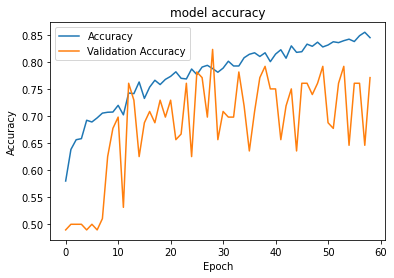

In [13]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

In [14]:
model.evaluate(traindata)

80/80 [==============================] - 31s 393ms/step - loss: 0.4134 - acc: 0.8206


[0.4133508801460266, 0.8205835819244385]

In [15]:
model.evaluate(validData)

4/4 [==============================] - 1s 305ms/step - loss: 0.4900 - acc: 0.7900


[0.4899631440639496, 0.7900000214576721]

In [16]:
model.evaluate(testdata)

10/10 [==============================] - 6s 573ms/step - loss: 0.5588 - acc: 0.7533


[0.5588394403457642, 0.753333330154419]

In [17]:
print(cal_steps(traindata.samples, batch_size))

79
